<h1> Homework 3 </h1>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.init as init
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import os
import time

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

<h2> Problem 1: Adaptive Learning Rate Methods, CIFAR-10

<p>1.

**AdaGrad**: Weight update equation is $$\theta_{t+1}=\theta_{t}-\frac{\eta}{\sqrt{G_t + \epsilon}}g_t$$ $\theta$ is the model parameter, $\eta$ is learning rate, $G_t$ is a diagonal matrix where each diagonal element is the sum of the squares of gradients of a parameter up to time t, $\epsilon$ is to avoid dividing by 0, $g_t$ is the gradient at time t. The hyperparameters are learning rate $\eta$ and $\epsilon$. 


**RMSProp**: Weight update equation is $$E[g^2]_t=\gamma E[g^2]_{t-1}+ (1-\gamma) g_t^{2}$$ $$\theta_{t+1}=\theta_{t}-\frac{\eta}{\sqrt{E[g^2]_t + \epsilon}}g_t$$ Most of terms are similar to AdaGrad, $E[g^2]_t$ is the running average of square of gradient at time t, and $\gamma$ is the decay rate. The hyperparameters are learning rate $\eta$, decay rate $\gamma$ and $\epsilon$.


**RMSProp+Nesterov**: Weight update equation is $$E[g^2]_t=\gamma E[g^2]_{t-1}+ (1-\gamma) g_t^{2}$$ $$v_t=\mu v_{t-1} - \frac{\eta}{\sqrt{E[g^2]_t + \epsilon}}g_t$$ $$\theta_{t+1}=\theta_{t} + v_t$$ And now $g_t=\Delta l(\theta_t + \mu v_{t-1} )$. Here, $v_t$ is the momentum term, and $\mu$ is the momentum rate. The hyperparameters are learning rate $\eta$, decay rate $\gamma$, momentum rate $\mu$ and $\epsilon$.


**AdaDelta**: Weight update equation is $$E[g^2]_t=\gamma E[g^2]_{t-1}+ (1-\gamma) g_t^{2}$$ $$\Delta \theta_t = -\frac{\eta}{\sqrt{E[g^2]_t + \epsilon}}g_t$$ $$E[\theta^2]_t=\gamma E[\theta^2]_{t-1}+ (1-\gamma) \theta_t^{2}$$ $$\theta_{t+1}=\theta_{t}-\frac{\sqrt{E[\theta^2]_t + \epsilon}}{\sqrt{E[g^2]_t + \epsilon}}g_t$$ The hyperparameters are learning rate $\eta$, decay rate $\gamma$ and $\epsilon$.


**Adam**: Weight update equation is $$m_t = \beta_1 m_{t-1} + (1-\beta_1) g_t$$ $$v_t = \beta_2 v_{t-1} + (1-\beta_2) g_t^{2}$$ $$\hat{m_t}=\frac{m_t}{1-\beta_1^{t}}$$ $$\hat{v_t}=\frac{v_t}{1-\beta_2^{t}}$$ $$\theta_{t+1} = \theta_t - \frac{\eta}{\sqrt{\hat{v_t}} + \epsilon}\hat{m_t}$$ Now $m_t$ is the exponentially decaying average of past gradients, $\hat{m_t}$ and $\hat{v_t}$ are the debias estimation. Hyperparameters are learning rate $\eta$, decay rate $\beta_1$ and $\beta_2$, and $\epsilon$.


The difference between AdaDelta and RMSProp is AdaDelta decaying average the square of parameters update vector. And the difference between Adam and RMSProp is Adam also considers the exponentially decaying avarage of past gradients, in other words, Adam considers both the first and second moment.
</p>

Files already downloaded and verified
Test accuracy of AdaGrad: 52 %
training time is 1016.2890837192535
Test accuracy of RMSProp: 40 %
training time is 1019.7486860752106
Test accuracy of RMSProp+Nesterov: 42 %
training time is 1050.7173008918762
Test accuracy of AdaDelta: 44 %
training time is 1081.0867331027985
Test accuracy of Adam: 42 %
training time is 1070.6766934394836


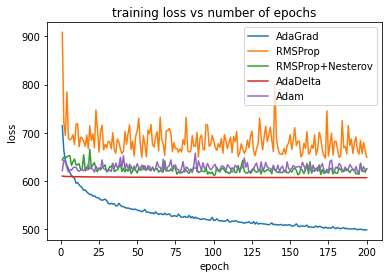

In [5]:
# 2.
class CIFAR_network(nn.Module):
    def __init__(self):
        super(CIFAR_network, self).__init__()
        self.fc1 = nn.Linear(3072, 1000)
        self.fc2 = nn.Linear(1000, 1000)
        self.fc3 = nn.Linear(1000, 10)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

def initialize_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight.data,nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias.data, 0)

dataset = torchvision.datasets.CIFAR10(root='data/', download=True, transform=torchvision.transforms.ToTensor())
test_dataset = torchvision.datasets.CIFAR10(root='data/', train=False, transform=torchvision.transforms.ToTensor())

batch_size = 128
train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, num_workers=4)

net = CIFAR_network()
net = net.to(device)
net = net.apply(initialize_weights)

criterion = nn.CrossEntropyLoss()

methods = ['AdaGrad', 'RMSProp', 'RMSProp+Nesterov', 'AdaDelta', 'Adam']
optimizers = [optim.Adagrad(net.parameters(), lr=0.001, weight_decay=0.01), optim.RMSprop(net.parameters(), lr=0.001, weight_decay=0.01), optim.NAdam(net.parameters(), lr=0.001, weight_decay=0.01), optim.Adadelta(net.parameters(), lr=0.001, weight_decay=0.01), optim.Adam(net.parameters(), lr=0.001, weight_decay=0.01)] 

for j in range(len(optimizers)):
    optimizer = optimizers[j]
    x = [i+1 for i in range(200)]
    y = []
    t1 = time.time()
    for epoch in range(200):
        training_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        with torch.no_grad():
            for i, data in enumerate(train_loader, 0):
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = net(inputs)
                loss = criterion(outputs, labels)
                training_loss += loss
        # print('epoch: ' + str(epoch) + ', loss: ' + str(training_loss))
        y.append(training_loss.to('cpu'))
    plt.plot(x, y, label=methods[j])
    correct = 0
    total = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            # calculate outputs by running images through the network
            outputs = net(images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Test accuracy of {methods[j]}: {100 * correct // total} %')
    print('training time is ' + str(time.time()-t1))

plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('training loss vs number of epochs')
plt.legend()
plt.show()

<p> From the figure, we can find that AdaGrad performs best. </p>

Files already downloaded and verified
Test accuracy of AdaGrad: 46 %
training time is 1058.349880695343
Test accuracy of RMSProp: 24 %
training time is 1081.6963155269623
Test accuracy of RMSProp+Nesterov: 27 %
training time is 1105.4541041851044
Test accuracy of AdaDelta: 28 %
training time is 1090.5661764144897
Test accuracy of Adam: 21 %
training time is 1063.1271314620972


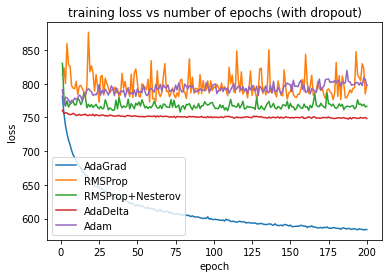

In [6]:
# 3.
class CIFAR_network(nn.Module):
    def __init__(self):
        super(CIFAR_network, self).__init__()
        self.fc1 = nn.Linear(3072, 1000)
        self.fc2 = nn.Linear(1000, 1000)
        self.fc3 = nn.Linear(1000, 10)
        self.dropout1 = nn.Dropout(0.2)
        self.dropout2 = nn.Dropout(0.5)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.dropout1(x)
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

def initialize_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight.data,nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias.data, 0)

dataset = torchvision.datasets.CIFAR10(root='data/', download=True, transform=torchvision.transforms.ToTensor())
test_dataset = torchvision.datasets.CIFAR10(root='data/', train=False, transform=torchvision.transforms.ToTensor())

batch_size = 128
train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, num_workers=4)

net = CIFAR_network()
net = net.to(device)
net = net.apply(initialize_weights)

criterion = nn.CrossEntropyLoss()

methods = ['AdaGrad', 'RMSProp', 'RMSProp+Nesterov', 'AdaDelta', 'Adam']
optimizers = [optim.Adagrad(net.parameters(), lr=0.001, weight_decay=0.01), optim.RMSprop(net.parameters(), lr=0.001, weight_decay=0.01), optim.NAdam(net.parameters(), lr=0.001, weight_decay=0.01), optim.Adadelta(net.parameters(), lr=0.001, weight_decay=0.01), optim.Adam(net.parameters(), lr=0.001, weight_decay=0.01)] 

for j in range(len(optimizers)):
    optimizer = optimizers[j]
    x = [i+1 for i in range(200)]
    y = []
    t1 = time.time()
    for epoch in range(200):
        training_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        with torch.no_grad():
            for i, data in enumerate(train_loader, 0):
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = net(inputs)
                loss = criterion(outputs, labels)
                training_loss += loss
        # print('epoch: ' + str(epoch) + ', loss: ' + str(training_loss))
        y.append(training_loss.to('cpu'))
    plt.plot(x, y, label=methods[j])
    correct = 0
    total = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            # calculate outputs by running images through the network
            outputs = net(images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Test accuracy of {methods[j]}: {100 * correct // total} %')
    print('training time is ' + str(time.time()-t1))

plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('training loss vs number of epochs (with dropout)')
plt.legend()
plt.show()

<p> From the figure, we can see AdaGrad performs best. </p>

<p> 4. From the results of part 2 and part 3, we can know the test accuracy of five methods without dropout are all higher than the test accuracy of five methods with dropout. </p>

<h2> Problem 2: Data Parallelism in Pytorch</h2>

<p> The code is in folder 'Problem_2'. To run the code, use 'python3 main.py --bs batch_size --g num_of_gpu'. </p>

<center>Table 1: Speedup Measurement for different batch size</center>


| | Batch-size 32 per GPU | Batch-size 128 per GPU | Batch-szie 512 per GPU |
|----|------|----|-----| 
| | Time(sec) and Speedup | Time(sec) and Speedup |Time(sec) and Speedup |
|1-GPU|28.94, 1 |16.55, 1 |15.27, 1 |
|2-GPU| 61.23, 0.47|17.99, 0.92 |10.56, 1.45 |
|4-GPU|130.41, 0.22 | 19.01, 0.87 | 4.83, 3.16 |

<center>Table 2: Compute and Communication time for different batch size</center>


| | Batch-size 32 per GPU | Batch-size 128 per GPU | Batch-szie 512 per GPU |
|----|------|----|-----| 
| | Compute(sec) and Comm(sec) | Compute(sec) and Comm(sec) |Compute(sec) and Comm(sec) |
|2-GPU| 50.25, 10.98|14.86, 3.13 |9.25, 1.31 |
|4-GPU|101.63, 28.78 | 12.98, 6.03 | 2.83, 2.00 |

<p> 1. Result shows in Table 1. </p>

<p> 2. Results shows in Table 1. From the results, we can know that there has not scaling when batch size is small, since there has a large part of overhead about moving data, communication and synchronization. And with the increasing number of batch size, we can see there has a weak scaling when batch size is 512. </p>

<p> 3. Results shows in Table 2. In data parallelism, the only thing needed to communicate is parameter server send new weights to each computing unit, so take time in replicate function in pytorch. And compute time is total training time minus communication time. </p> 

<center>Table 3: Communication Bandwidth Utilization</center>


| | Batch-size 32 per GPU | Batch-size 128 per GPU | Batch-szie 512 per GPU |
|----|------|----|-----| 
| | Bandwidth Utilization (GB/s) | Bandwidth Utilization (GB/s) |Bandwidth Utilization (GB/s)|
|2-GPU| 16|64 |256 |
|4-GPU|8 | 32 | 128 |

<p> 4. Firstly, all-reduce algorithm takes $P-1$ iterations to scatter, and $P-1$ iterations to reduce, where P is the number of computing unit. So it takes $2(P-1)$ times to finish all allreduce. Then total data transferred is $2(P-1)\frac{N}{P}$ where $N$ is the total number of parameters. Therefore, bandwidth is $2(P-1)\frac{N}{P} / 2(P-1) = \frac{N}{P}$.

<h2> Problem 3: Convolutional Neural Networks Architectures

<p> 1. </p>


| Layer Name  | Tensor Size | Parameters | Description |
| ----------- | ----------- | -----------|-------------|
| Input      | 227x227x3   | 0 | 
| Conv-1   | 55x55x96 | (11 x 11 x 3 + 1) x 96 = 34944 | filter size: 11x11, #of filters: 94, stride: 4
| MaxPool-1 | 27x27x96 | 0 |filter size: 3x3, stride: 2 |
|Conv-2|27x27x256| (5 x 5 x 96 + 1) x 256 = 614656| filter size: 5x5, #of filters: 256, stride: 1, padding: 2|
|MaxPool-2|13x13x256| 0 | filter size: 3x3, stride: 2|
|Conv-3| 13x13x384 | (3 x 3 x 256 + 1) x 384 = 885120 | filter size: 3x3, #of filters: 384, stride: 1, padding: 1| 
| Conv-4 | 13x13x384 | (3 x 3 x 384 + 1) x 384 = 1327488 | filter size: 3x3, #of filters: 384, stride: 1, padding: 1 | 
| Conv-5 | 13x13x256 | (3 x 3 x 384 + 1) x 256 = 884992 | filter size: 3x3, #of filters: 256, stride: 1, padding: 1 |
| MaxPool-3 | 6x6x256 | 0 | filter size: 3x3, stride: 2|
| FC-1 | 4096x1 | (256 x 6 x 6 + 1) x 4096 = 37752832 | |
| FC-2 | 4096x1 | (4096 + 1) x 4096 = 16781312 | |
| FC-3 | 1000x1 | (4096 + 1) x 4096 = 4097000 | | 

Therefore, the total number of parameters is 62378344.

| Layer | Number of Activations (Memory) | Parameters (Compute) |
| ---- | ----- | ----- |
| Input | 224x224x3=150K | 0 |
| CONV3-64 | 224x224x64=3.2M | (3x3x3)x64=1728 |
| CONV3-64 | 224x224x64=3.2M | (3x3x64)x64=36864 |
| POOL2 | 112x112x64=800K | 0 |
| CONV3-128 | 112x112x128=1.6M | (3x3x64)x128=73728|
| CONV3-128 | 112x112x128=1.6M | (3x3x128)x128=147456 |
|POOL2 | 56x56x128=400K | 0|
| CONV3-256 | 56x56x256=800K | (3x3x128)x256=294912 |
| CONV3-256 | 56x56x256=800K | (3x3x256)x256=589824 |
| CONV3-256 | 56x56x256=800K | (3x3x256)x256=589824 |
| CONV3-256 | 56x56x256=800K | (3x3x256)x256=589824 |
| POOL2 | 28x28x256=200K | 0 |
| CONV3-512 | 28x28x512=400K | (3x3x256)x512=1179648 |
| CONV3-512 | 28x28x512=400K | (3x3x512)x512=2359296 |
| CONV3-512 | 28x28x512=400K | (3x3x512)x512=2359296 |
| CONV3-512 | 28x28x512=400K | (3x3x512)x512=2359296 |
| POOL2 | 14x14x512=100K | 0 |
| CONV3-512 | 14x14x512=100K | (3x3x512)x512=2359296 |
| CONV3-512 | 14x14x512=100K | (3x3x512)x512=2359296 |
| CONV3-512 | 14x14x512=100K | (3x3x512)x512=2359296 |
| CONV3-512 | 14x14x512=100K | (3x3x512)x512=2359296 |
| POOL2 | 7x7x512=25K | 0 |
| FC | 4096 | (7x7x512)x4096=102760448 | 
| FC | 4096 | 4096x4096=16777216 | 
| FC | 1000 | 4096x1000=4096000 | 
| TOTAL | 16M | 143652544 | 


<p> 3. The output activation map of first stack in N consecutive stacks is $$L-F+1$$ Repeat it N times is $$(L-N(F-1))-F+1=L-NF+N$$. The receptive field of filter size $NF-N+1$ is $$L-(NF-N+1)+1=L-NF+N$$ Therefore, the receptive field of 3 filters of size 5x5 is 20 x 20 feature map since $32 - 3x5+3=20$. 

<p> 4. 

(a) The general idea behind designing an inception module is to maintain sparsity to keep the realatively reasonable training time and model size, and able to extract features of different sizes at the same time.

(b) For naive version, the output size is 32x32x(128+192+96+256) = 32x32x672.
For dimension reductions version, the output size is 32x32x(128+192+96+64) = 32x32x480.

(c) For naive version, 

1x1 CONV = 32 x 32 x 1 x 256 x 128 = 33554432

3x3 CONV = 32 x 32 x 9 x 256 x 128 = 301989888

5x5 CONV = 32 x 32 x 25 x 256 x 128 = 838860800

Total = 1174405120

For dimension reductions version, 

1x1 CONV = (32 x 32 x 256 x 128) + (32 x 32 x 256 x 128) + (32 x 32 x 256 x 64) = 92274688

3x3 CONV = 32 x 32 x 9 x 128 x 192 = 226492416

5x5 CONV = 32 x 32 x 25 x 32 x 96 = 78643200

Total = 397410304

(d) The problem of naive version is still has many parameters to learn, and the dimensionality reduction version reduces the dimension. And the computational saving is about 2.96 times when compared with naive version.

<p> 5.

(a) The main difference is Fast-RCNN uses selective search to extract region proposal, whereas Faster-RCNN uses Region Propose Network to extract, which can save much time.

(b) RPN is a network that produces anchor boxes of different scales and aspect ratios, can predict object bounds and objectness scores simultaneously at each position.

(c) Based on the figure below, RPN defines k anchor boxes, and anchor is the central point of the sliding window. RPN has a classifier and a regressor. Classifier determines the probability of a proposal having the target object and regressor regress the coordinates of the proposals. 

![fishy](./1_JDQw0RwmnIKeRABw3ZDI7Q.png)

(d) The technique uesd to reduce overlapping proposals is non-maximum suppression. It will iteratively researves the proposal that has the highest score.

![fishy](./1_6d_D0ySg-kOvfrzIRwHIiA.png)
</p>

<h2> Problem 4: Batch Augmentation, Cutout Regularization

<p> 1. Cutout regularization is to remove contigious sections of images, which can augment the dataset and incease both generalization and performance scaling. The advantages over dropout is cutout regularization can take more of the full image context, rather than key features, into consideration, so it will force model to understand content in a global view. And cutout regularization only apply on the input stage, which has the consistency in the whole network.</p>

Files already downloaded and verified


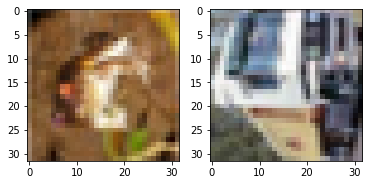

In [ ]:
dataset = torchvision.datasets.CIFAR10(root='data/', download=True, transform=torchvision.transforms.ToTensor())
plt.subplot(1,2,1)
plt.imshow(dataset[0][0].T)
plt.subplot(1,2,2)
plt.imshow(dataset[1][0].T)

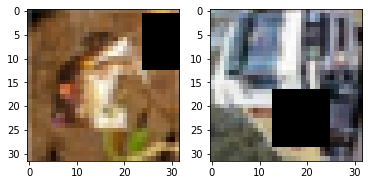

In [ ]:
def mask(image):
    h, w, channels = image.shape
    new_image = image
    y = np.random.randint(h)
    x = np.random.randint(w)
    y1 = np.clip(y - 12 // 2, 0, h)
    y2 = np.clip(y + 12 // 2, 0, h)
    x1 = np.clip(x - 12 // 2, 0, w)
    x2 = np.clip(x + 12 // 2, 0, w)
    new_image[y1:y2,x1:x2,:] = 0
    return new_image
plt.subplot(1,2,1)
plt.imshow(mask(dataset[0][0].T))
plt.subplot(1,2,2)
plt.imshow(mask(dataset[1][0].T))

<p> 2. Credit: https://colab.research.google.com/github/seyrankhademi/ResNet_CIFAR10/blob/master/CIFAR10_ResNet.ipynb </p>

Files already downloaded and verified
Epoch: [0][0/782]	Loss 5.5112 (5.5112)	Prec@1 1.562 (1.562)
Test	  Prec@1: 34.810 (Err: 65.190 )

Epoch: [1][0/782]	Loss 1.7572 (1.7572)	Prec@1 39.062 (39.062)
Test	  Prec@1: 41.160 (Err: 58.840 )

Epoch: [2][0/782]	Loss 1.2651 (1.2651)	Prec@1 51.562 (51.562)
Test	  Prec@1: 60.010 (Err: 39.990 )

Epoch: [3][0/782]	Loss 0.9711 (0.9711)	Prec@1 65.625 (65.625)
Test	  Prec@1: 68.260 (Err: 31.740 )

Epoch: [4][0/782]	Loss 1.0584 (1.0584)	Prec@1 59.375 (59.375)
Test	  Prec@1: 77.080 (Err: 22.920 )

Epoch: [5][0/782]	Loss 0.4789 (0.4789)	Prec@1 84.375 (84.375)
Test	  Prec@1: 75.820 (Err: 24.180 )

Epoch: [6][0/782]	Loss 0.6056 (0.6056)	Prec@1 79.688 (79.688)
Test	  Prec@1: 79.240 (Err: 20.760 )

Epoch: [7][0/782]	Loss 0.3703 (0.3703)	Prec@1 89.062 (89.062)
Test	  Prec@1: 80.910 (Err: 19.090 )

Epoch: [8][0/782]	Loss 0.6888 (0.6888)	Prec@1 75.000 (75.000)
Test	  Prec@1: 79.850 (Err: 20.150 )

Epoch: [9][0/782]	Loss 0.5738 (0.5738)	Prec@1 78.125 (78.125)
Te

Epoch: [81][0/782]	Loss 0.3744 (0.3744)	Prec@1 92.188 (92.188)
Test	  Prec@1: 85.780 (Err: 14.220 )

Epoch: [82][0/782]	Loss 0.2857 (0.2857)	Prec@1 90.625 (90.625)
Test	  Prec@1: 83.200 (Err: 16.800 )

Epoch: [83][0/782]	Loss 0.1972 (0.1972)	Prec@1 95.312 (95.312)
Test	  Prec@1: 88.200 (Err: 11.800 )

Epoch: [84][0/782]	Loss 0.1027 (0.1027)	Prec@1 98.438 (98.438)
Test	  Prec@1: 85.710 (Err: 14.290 )

Epoch: [85][0/782]	Loss 0.1784 (0.1784)	Prec@1 92.188 (92.188)
Test	  Prec@1: 86.720 (Err: 13.280 )

Epoch: [86][0/782]	Loss 0.4336 (0.4336)	Prec@1 84.375 (84.375)
Test	  Prec@1: 86.260 (Err: 13.740 )

Epoch: [87][0/782]	Loss 0.2312 (0.2312)	Prec@1 90.625 (90.625)
Test	  Prec@1: 87.150 (Err: 12.850 )

Epoch: [88][0/782]	Loss 0.1948 (0.1948)	Prec@1 93.750 (93.750)
Test	  Prec@1: 87.960 (Err: 12.040 )

Epoch: [89][0/782]	Loss 0.1445 (0.1445)	Prec@1 96.875 (96.875)
Test	  Prec@1: 86.210 (Err: 13.790 )

Epoch: [90][0/782]	Loss 0.1949 (0.1949)	Prec@1 93.750 (93.750)
Test	  Prec@1: 84.900 (Err: 

Test	  Prec@1: 93.350 (Err: 6.650 )

Epoch: [162][0/782]	Loss 0.0142 (0.0142)	Prec@1 100.000 (100.000)
Test	  Prec@1: 93.040 (Err: 6.960 )

Epoch: [163][0/782]	Loss 0.0131 (0.0131)	Prec@1 100.000 (100.000)
Test	  Prec@1: 93.180 (Err: 6.820 )

Epoch: [164][0/782]	Loss 0.0033 (0.0033)	Prec@1 100.000 (100.000)
Test	  Prec@1: 93.270 (Err: 6.730 )

Epoch: [165][0/782]	Loss 0.0021 (0.0021)	Prec@1 100.000 (100.000)
Test	  Prec@1: 93.300 (Err: 6.700 )

Epoch: [166][0/782]	Loss 0.0009 (0.0009)	Prec@1 100.000 (100.000)
Test	  Prec@1: 93.220 (Err: 6.780 )

Epoch: [167][0/782]	Loss 0.0032 (0.0032)	Prec@1 100.000 (100.000)
Test	  Prec@1: 93.250 (Err: 6.750 )

Epoch: [168][0/782]	Loss 0.0005 (0.0005)	Prec@1 100.000 (100.000)
Test	  Prec@1: 93.200 (Err: 6.800 )

Epoch: [169][0/782]	Loss 0.0114 (0.0114)	Prec@1 100.000 (100.000)
Test	  Prec@1: 93.250 (Err: 6.750 )

Epoch: [170][0/782]	Loss 0.0029 (0.0029)	Prec@1 100.000 (100.000)
Test	  Prec@1: 93.160 (Err: 6.840 )

Epoch: [171][0/782]	Loss 0.0026 (0.0

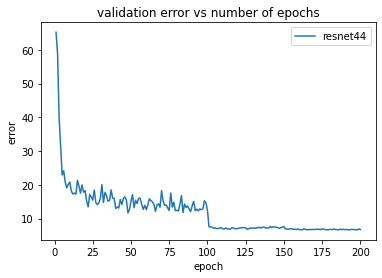

In [7]:
__all__ = ['resnet44']
validation_error = []
 
def _weights_init(m):
    """
        Initialization of CNN weights
    """
    classname = m.__class__.__name__
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        init.kaiming_normal_(m.weight)


class LambdaLayer(nn.Module):
    """
      Identity mapping between ResNet blocks with diffrenet size feature map
    """
    def __init__(self, lambd):
        super(LambdaLayer, self).__init__()
        self.lambd = lambd

    def forward(self, x):
        return self.lambd(x)

# A basic block as shown in Fig.3 (right) in the paper consists of two convolutional blocks, each followed by a Bach-Norm layer. 
# Every basic block is shortcuted in ResNet architecture to construct f(x)+x module. 
# Expansion for option 'A' in the paper is equal to identity with extra zero entries padded
# for increasing dimensions between layers with different feature map size. This option introduces no extra parameter. 
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, option='A'):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            if option == 'A':
                """
                For CIFAR10 experiment, ResNet paper uses option A.
                """
                self.shortcut = LambdaLayer(lambda x:
                                            F.pad(x[:, :, ::2, ::2], (0, 0, 0, 0, planes//4, planes//4), "constant", 0))
            elif option == 'B':
                self.shortcut = nn.Sequential(
                     nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                     nn.BatchNorm2d(self.expansion * planes)
                )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

# Stack of 3 times 2*n (n is the number of basic blocks) layers are used for making the ResNet model, 
# where each 2n layers have feature maps of size {16,32,64}, respectively. 
# The subsampling is performed by convolutions with a stride of 2.
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 16
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 64, num_blocks[2], stride=2)
        self.linear = nn.Linear(64, num_classes)
        self.apply(_weights_init)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion

        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.avg_pool2d(out, out.size()[3])
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def resnet44():
    return ResNet(BasicBlock, [7, 7, 7])


class MyResNetArgs:
   """
    Passing the hyperparameters to the model
   """
   def __init__(self, arch='resnet44' ,epochs=200, start_epoch=0, batch_size=64, lr=0.1, momentum=0.9, weight_decay=1e-4, print_freq=782,
                 evaluate=0, pretrained=0, half=0, save_dir='save_temp', save_every=10):
        self.save_every = save_every #Saves checkpoints at every specified number of epochs
        self.save_dir = save_dir #The directory used to save the trained models
        self.half = half #use half-precision(16-bit)
        self.evaluate = evaluate #evaluate model on the validation set
        self.pretrained = pretrained #evaluate the pretrained model on the validation set
        self.print_freq = print_freq #print frequency 
        self.weight_decay = weight_decay
        self.momentum = momentum 
        self.lr = lr #Learning rate
        self.batch_size = batch_size 
        self.start_epoch = start_epoch
        self.epochs = epochs
        self.arch = arch #ResNet model

args=MyResNetArgs('resnet44',pretrained=0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
best_prec1 = 0

def train(train_loader, model, criterion, optimizer, epoch):
    """
        Run one train epoch
    """
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()

    # switch to train mode
    model.train()

    end = time.time()
    for i, (input, target) in enumerate(train_loader):

        # measure data loading time
        data_time.update(time.time() - end)

        target = target.to(device)
        input_var = input.to(device)
        target_var = target
        if args.half:
            input_var = input_var.half()

        # compute output
        output = model(input_var)
        loss = criterion(output, target_var)

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        output = output.float()
        loss = loss.float()
        # measure accuracy and record loss
        prec1 = accuracy(output.data, target)[0]
        losses.update(loss.item(), input.size(0))
        top1.update(prec1.item(), input.size(0))

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if i % args.print_freq == 0:
            print('Epoch: [{0}][{1}/{2}]\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Prec@1 {top1.val:.3f} ({top1.avg:.3f})'.format(
                      epoch, i, len(train_loader), batch_time=batch_time,
                      data_time=data_time, loss=losses, top1=top1))

def validate(val_loader, model, criterion):
    """
    Run evaluation
    """
    batch_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()

    # switch to evaluate mode
    model.eval()

    end = time.time()
    with torch.no_grad():
        for i, (input, target) in enumerate(val_loader):
            target = target.to(device)
            input_var = input.to(device)
            target_var = target.to(device)

            if args.half:
                input_var = input_var.half()

            # compute output
            output = model(input_var)
            loss = criterion(output, target_var)

            output = output.float()
            loss = loss.float()

            # measure accuracy and record loss
            prec1 = accuracy(output.data, target)[0]
            losses.update(loss.item(), input.size(0))
            top1.update(prec1.item(), input.size(0))

            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()


    print('Test\t  Prec@1: {top1.avg:.3f} (Err: {error:.3f} )\n'
          .format(top1=top1,error=100-top1.avg))
    validation_error.append(100-top1.avg)
    return top1.avg

def save_checkpoint(state, filename='checkpoint.th'):
    """
    Save the training model
    """
    torch.save(state, filename)


class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])

train_loader = torch.utils.data.DataLoader(
        datasets.CIFAR10(root='./data', train=True, transform=transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomCrop(32, 4),
            transforms.ToTensor(),
            normalize,
        ]), download=True),
        batch_size=args.batch_size, shuffle=True,
        num_workers=4, pin_memory=True)

val_loader = torch.utils.data.DataLoader(
        datasets.CIFAR10(root='./data', train=False, transform=transforms.Compose([
            transforms.ToTensor(),
            normalize,
        ])),
        batch_size=64, shuffle=False,
        num_workers=4, pin_memory=True)

def main():
    global args, best_prec1
    
    # Check the save_dir exists or not
    if not os.path.exists(args.save_dir):
        os.makedirs(args.save_dir)

    model = resnet44().to(device)


    # define loss function (criterion) and pptimizer
    criterion = nn.CrossEntropyLoss().to(device)

    if args.half:
        print('half persicion is used.')
        model.half()
        criterion.half()

    optimizer = torch.optim.SGD(model.parameters(), args.lr,
                                momentum=args.momentum,
                                weight_decay=args.weight_decay)

    lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer,
                                                        milestones=[100, 150], last_epoch=args.start_epoch - 1)

    if args.evaluate:
        print('evalution mode')
        model.load_state_dict(torch.load(os.path.join(args.save_dir, 'model.th')))
        best_prec1 = validate(val_loader, model, criterion)
        return best_prec1

    if args.pretrained:
        print('evalution of pretrained model')
        args.save_dir='pretrained_models'
        pretrained_model= args.arch +'.th'
        model.load_state_dict(torch.load(os.path.join(args.save_dir, pretrained_model)))
        best_prec1 = validate(val_loader, model, criterion)
        return best_prec1

    for epoch in range(args.start_epoch, args.epochs):

        # train for one epoch
        train(train_loader, model, criterion, optimizer, epoch)
        lr_scheduler.step()

        # evaluate on validation set
        prec1 = validate(val_loader, model, criterion)

        # remember best prec@1 and save checkpoint
        is_best = prec1 > best_prec1
        best_prec1 = max(prec1, best_prec1)

        if epoch > 0 and epoch % args.save_every == 0:
            save_checkpoint(model.state_dict(), filename=os.path.join(args.save_dir, 'checkpoint.th'))
        if is_best:
            save_checkpoint(model.state_dict(), filename=os.path.join(args.save_dir, 'model.th'))

    return best_prec1

best_prec1 = main()

x = [i+1 for i in range(200)]
plt.plot(x, validation_error, label='resnet44')
plt.xlabel('epoch')
plt.ylabel('error')
plt.title('validation error vs number of epochs')
plt.legend()
plt.show()

<p> 3. Credit: https://github.com/uoguelph-mlrg/Cutout </p>

Files already downloaded and verified
Files already downloaded and verified
m=2, wallclock time is 5342.184479236603
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
m=4, wallclock time is 5626.209480524063
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
m=8, wallclock time is 10310.90196442604
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Fil

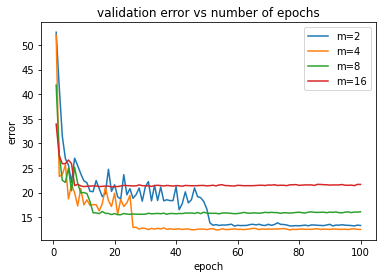

In [17]:
__all__ = ['resnet44']
validation_error = []


def _weights_init(m):
    """
        Initialization of CNN weights
    """
    classname = m.__class__.__name__
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        init.kaiming_normal_(m.weight)
        
        
class Cutout(object):
    """Randomly mask out one or more patches from an image.
    Args:
        n_holes (int): Number of patches to cut out of each image.
        length (int): The length (in pixels) of each square patch.
    """
    def __init__(self, n_holes, length):
        self.n_holes = n_holes
        self.length = length

    def __call__(self, img):
        """
        Args:
            img (Tensor): Tensor image of size (C, H, W).
        Returns:
            Tensor: Image with n_holes of dimension length x length cut out of it.
        """
        h = img.size(1)
        w = img.size(2)

        mask = np.ones((h, w), np.float32)

        for n in range(self.n_holes):
            y = np.random.randint(h)
            x = np.random.randint(w)

            y1 = np.clip(y - self.length // 2, 0, h)
            y2 = np.clip(y + self.length // 2, 0, h)
            x1 = np.clip(x - self.length // 2, 0, w)
            x2 = np.clip(x + self.length // 2, 0, w)

            mask[y1: y2, x1: x2] = 0.

        mask = torch.from_numpy(mask)
        mask = mask.expand_as(img)
        img = img * mask

        return img


class LambdaLayer(nn.Module):
    """
      Identity mapping between ResNet blocks with diffrenet size feature map
    """
    def __init__(self, lambd):
        super(LambdaLayer, self).__init__()
        self.lambd = lambd

    def forward(self, x):
        return self.lambd(x)

# A basic block as shown in Fig.3 (right) in the paper consists of two convolutional blocks, each followed by a Bach-Norm layer. 
# Every basic block is shortcuted in ResNet architecture to construct f(x)+x module. 
# Expansion for option 'A' in the paper is equal to identity with extra zero entries padded
# for increasing dimensions between layers with different feature map size. This option introduces no extra parameter. 
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, option='A'):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            if option == 'A':
                """
                For CIFAR10 experiment, ResNet paper uses option A.
                """
                self.shortcut = LambdaLayer(lambda x:
                                            F.pad(x[:, :, ::2, ::2], (0, 0, 0, 0, planes//4, planes//4), "constant", 0))
            elif option == 'B':
                self.shortcut = nn.Sequential(
                     nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                     nn.BatchNorm2d(self.expansion * planes)
                )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

# Stack of 3 times 2*n (n is the number of basic blocks) layers are used for making the ResNet model, 
# where each 2n layers have feature maps of size {16,32,64}, respectively. 
# The subsampling is performed by convolutions with a stride of 2.
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 16
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 64, num_blocks[2], stride=2)
        self.linear = nn.Linear(64, num_classes)
        self.apply(_weights_init)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion

        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.avg_pool2d(out, out.size()[3])
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def resnet44():
    return ResNet(BasicBlock, [7, 7, 7])


class MyResNetArgs:
   """
    Passing the hyperparameters to the model
   """
   def __init__(self, arch='resnet44' ,epochs=100, start_epoch=0, batch_size=64, lr=0.1, momentum=0.9, weight_decay=1e-4, print_freq=782,
                 evaluate=0, pretrained=0, half=0, save_dir='save_temp', save_every=10):
        self.save_every = save_every #Saves checkpoints at every specified number of epochs
        self.save_dir = save_dir #The directory used to save the trained models
        self.half = half #use half-precision(16-bit)
        self.evaluate = evaluate #evaluate model on the validation set
        self.pretrained = pretrained #evaluate the pretrained model on the validation set
        self.print_freq = print_freq #print frequency 
        self.weight_decay = weight_decay
        self.momentum = momentum 
        self.lr = lr #Learning rate
        self.batch_size = batch_size 
        self.start_epoch = start_epoch
        self.epochs = epochs
        self.arch = arch #ResNet model

args=MyResNetArgs('resnet44',pretrained=0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
best_prec1 = 0

def train(train_loader, model, criterion, optimizer, epoch):
    """
        Run one train epoch
    """
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()

    # switch to train mode
    model.train()

    for i, (input, target) in enumerate(train_loader):

        target = target.to(device)
        input_var = input.to(device)
        target_var = target
        if args.half:
            input_var = input_var.half()

        # compute output
        output = model(input_var)
        loss = criterion(output, target_var)

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        output = output.float()
        loss = loss.float()
        # measure accuracy and record loss
        prec1 = accuracy(output.data, target)[0]
        losses.update(loss.item(), input.size(0))
        top1.update(prec1.item(), input.size(0))

def validate(val_loader, model, criterion):
    """
    Run evaluation
    """
    batch_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()

    # switch to evaluate mode
    model.eval()

    with torch.no_grad():
        for i, (input, target) in enumerate(val_loader):
            target = target.to(device)
            input_var = input.to(device)
            target_var = target.to(device)

            if args.half:
                input_var = input_var.half()

            # compute output
            output = model(input_var)
            loss = criterion(output, target_var)

            output = output.float()
            loss = loss.float()

            # measure accuracy and record loss
            prec1 = accuracy(output.data, target)[0]
            losses.update(loss.item(), input.size(0))
            top1.update(prec1.item(), input.size(0))

    return top1.avg

def save_checkpoint(state, filename='checkpoint.th'):
    """
    Save the training model
    """
    torch.save(state, filename)


class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])

def main():
    global best_prec1
    
    for m in [2, 4, 8, 16]:
        
        t1 = time.time()     
        best_prec1 = 0
        validation_error = []
        
        args.batch_size = 64 * m
        
        train_set = datasets.CIFAR10(root='./data', train=True, transform=transforms.Compose([
                transforms.ToTensor(),
                normalize, Cutout(n_holes=1, length=12),
            ]), download=True)
        
        for i in range(m-1):
            tmp_set = datasets.CIFAR10(root='./data', train=True, transform=transforms.Compose([
                transforms.ToTensor(),
                normalize, Cutout(n_holes=1, length=12),
            ]), download=True)
            train_set = torch.utils.data.ConcatDataset([train_set, tmp_set])
    
        train_loader = torch.utils.data.DataLoader(
            train_set,
            batch_size=args.batch_size, shuffle=True,
            num_workers=4, pin_memory=True)

        val_loader = torch.utils.data.DataLoader(
            datasets.CIFAR10(root='./data', train=False, transform=transforms.Compose([
                transforms.ToTensor(),
                normalize,
            ])),
            batch_size=64, shuffle=False,
            num_workers=4, pin_memory=True)

        # Check the save_dir exists or not
        if not os.path.exists(args.save_dir):
            os.makedirs(args.save_dir)

        model = resnet44().to(device)


        # define loss function (criterion) and pptimizer
        criterion = nn.CrossEntropyLoss().to(device)

        if args.half:
            model.half()
            criterion.half()

        optimizer = torch.optim.SGD(model.parameters(), args.lr,
                                    momentum=args.momentum,
                                    weight_decay=args.weight_decay)

        lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer,
                                                            milestones=[int(100/m), int(150/m)], last_epoch=args.start_epoch - 1)

        if args.evaluate:
            model.load_state_dict(torch.load(os.path.join(args.save_dir, 'model.th')))
            best_prec1 = validate(val_loader, model, criterion)
            return best_prec1

        if args.pretrained:
            args.save_dir='pretrained_models'
            pretrained_model= args.arch +'.th'
            model.load_state_dict(torch.load(os.path.join(args.save_dir, pretrained_model)))
            best_prec1 = validate(val_loader, model, criterion)
            return best_prec1
        
        count = 0
        
        for epoch in range(args.start_epoch, args.epochs):
            
            count += 1

            # train for one epoch
            train(train_loader, model, criterion, optimizer, epoch)
            lr_scheduler.step()

            # evaluate on validation set
            prec1 = validate(val_loader, model, criterion)
            validation_error.append(100.0-prec1)
            
            if prec1 > 92:
                break

            # remember best prec@1 and save checkpoint
            is_best = prec1 > best_prec1
            best_prec1 = max(prec1, best_prec1)

            if epoch > 0 and epoch % args.save_every == 0:
                save_checkpoint(model.state_dict(), filename=os.path.join(args.save_dir, 'checkpoint.th'))
            if is_best:
                save_checkpoint(model.state_dict(), filename=os.path.join(args.save_dir, 'model.th'))
        
        print('m=' + str(m) + ', wallclock time is ' + str(time.time()-t1))
        x = [i+1 for i in range(len(validation_error))]
        plt.plot(x, validation_error, label='m=' + str(m))


main()

plt.xlabel('epoch')
plt.ylabel('error')
plt.title('validation error vs number of epochs')
plt.legend()
plt.show()